### Take the tile-30-95 as example.


In [1]:
import matplotlib.pyplot as plt
from utils.get_dem import get_dem
from utils.geotif_io import readTiff
from utils.raster_vec import vec2mask
from utils.transform_xy import geo2imagexy
from utils.crop_to_extent import crop_to_extent
from osgeo import gdal
from glob import glob
import numpy as np
import pyproj
import h5py


ERROR 1: PROJ: proj_create_from_database: Open of /home/xin/miniconda3/envs/venv-glacier/share/proj failed


In [2]:
### Tile number determination
extent_bottom, extent_left = 30, 95


### Dem data.

In [3]:
path_srtm = 'data/dem-data/srtm-c/tiles/tile-'+str(extent_bottom)+'-'+str(extent_left)+'_albers.tif'
srtm, srtm_info = readTiff(path_srtm)
srtm[srtm<0]=0
srtm.shape


(4028, 3502)

### Water mask

In [4]:
path_wat = 'data/water/water-jrc/tiles/tile-'+str(extent_bottom)+'-'+str(extent_left)+'_albers.tif'
mask_wat = crop_to_extent(path_img=path_wat, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
mask_wat = np.int8(mask_wat)
mask_wat.shape


(4028, 3502)

### Globeland30 data and extract the forest/shrup coverage.

In [5]:
path_gl30 = 'data/globeland30/2020/tiles/tile-'+str(extent_bottom)+'-'+str(extent_left)+'_albers.tif'
gl30 = crop_to_extent(path_img=path_gl30, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
mask_forest = np.where((gl30==20) | (gl30==40), 1, 0)  # extract forest/shrup from the gl30 data
mask_forest.shape


(4028, 3502)

### Glacier mask

In [6]:
path_glacier = 'data/rgi60/tiles/tile-'+str(extent_bottom)+'-'+str(extent_left)+'_albers.tif'
mask_glacier = crop_to_extent(path_img=path_glacier, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
# mask_glacier, mask_glacier_info = readTiff(path_glacier)
mask_glacier[mask_glacier<0]=0
mask_glacier = np.int8(mask_glacier)
mask_glacier.shape


(4028, 3502)

#### Statistic of the glacier area of each 100-m elevation bin

In [7]:
### Statistic of the glacier area of each 100-m elevation bin.
glacier_area_bins = {}
glacier_area = 0
srtm_glacier = srtm*mask_glacier
srtm_glacier_ = srtm_glacier[srtm_glacier>0]
h_start, h_end = np.nanmin(srtm_glacier_), np.nanmax(srtm_glacier_)
bin_start, bin_end = np.floor(h_start/100)*100, np.ceil(h_end/100)*100
print("bin_start, bin_end: ",bin_start, bin_end)
num_bin = ((bin_end - bin_start)/100).astype(int)
for i in range(num_bin):
  start, end = bin_start + i*100,  bin_start + i*100 + 100
  ids_pixels_bin = np.where((srtm_glacier > start) & (srtm_glacier < end))[0]
  area_pixels_bin = ids_pixels_bin.shape[0]*0.03*0.03   ### the height and width of pixel is 0.03 km
  glacier_area_bins[str(start.astype(int))+'-'+str(end.astype(int))] = area_pixels_bin
  glacier_area += area_pixels_bin
print('overall glacier area (km2):', glacier_area)
print(glacier_area_bins.keys())


bin_start, bin_end:  3200.0 6300.0
overall glacier area (km2): 670.4298
dict_keys(['3200-3300', '3300-3400', '3400-3500', '3500-3600', '3600-3700', '3700-3800', '3800-3900', '3900-4000', '4000-4100', '4100-4200', '4200-4300', '4300-4400', '4400-4500', '4500-4600', '4600-4700', '4700-4800', '4800-4900', '4900-5000', '5000-5100', '5100-5200', '5200-5300', '5300-5400', '5400-5500', '5500-5600', '5600-5700', '5700-5800', '5800-5900', '5900-6000', '6000-6100', '6100-6200', '6200-6300'])


Text(0.5, 1.0, 'globeland30 forest')

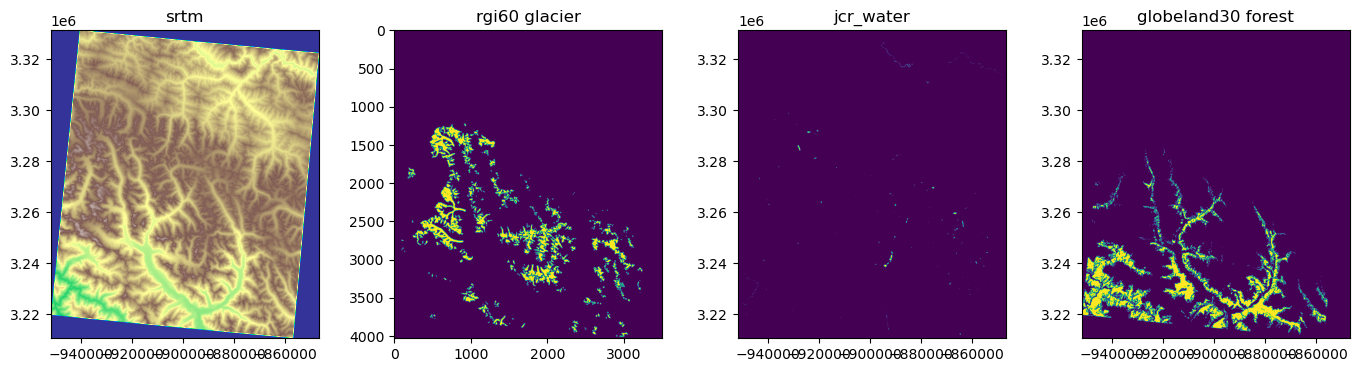

In [8]:
plt.figure(figsize=(17,4))
plt.subplot(1,4,1)
plt.imshow(srtm, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.title('srtm')
plt.subplot(1,4,2)
plt.imshow(mask_glacier);
plt.title('rgi60 glacier')
plt.subplot(1,4,3)
plt.imshow(mask_wat, extent=srtm_info['geoextent'])
plt.title('jcr_water')
plt.subplot(1,4,4)
plt.imshow(mask_forest, extent=srtm_info['geoextent'])
plt.title('globeland30 forest')


### Read icesat data

In [9]:
paths_atl06 = glob('data/icesat/ATL06-2020/tile-30-95/*_readout.h5')
print(paths_atl06[0])
print('Number of icesat2 files: ', len(paths_atl06))


data/icesat/ATL06-2020/tile-30-95/processed_ATL06_20200404072620_01340702_005_01_readout.h5
Number of icesat2 files:  33


In [10]:
!h5ls data/icesat/ATL06-2020/tile-30-95/processed_ATL06_20200404072620_01340702_005_01_readout.h5


beam_type                Dataset {3929}
cycle                    Dataset {3929}
h_lat                    Dataset {3929}
h_li                     Dataset {3929}
h_lon                    Dataset {3929}
orbit_type               Dataset {3929}
rgt                      Dataset {3929}
spot                     Dataset {3929}
t_dyr                    Dataset {3929}


In [11]:
### read icesat-2 data
keys = ['lon', 'lat', 'h', 't_dyr']   ## output variables
isat2 = {}
for key in keys: 
    isat2[key]=np.array([]); 
for path in paths_atl06:
    with h5py.File(path,'r') as f_atl06:
        isat2['lon'] = np.concatenate((isat2['lon'], f_atl06['h_lon'][:])) 
        isat2['lat'] = np.concatenate((isat2['lat'], f_atl06['h_lat'][:])) 
        isat2['h'] = np.concatenate((isat2['h'], f_atl06['h_li'][:]))  
        isat2['t_dyr'] = np.concatenate((isat2['t_dyr'], f_atl06['t_dyr'][:])) 


In [12]:
### Filter out the the points out of the dem tile extent.
srtm_gdal = gdal.Open(path_srtm); srtm_proj = srtm_gdal.GetProjection()
transformer = pyproj.Transformer.from_crs('epsg:4326', srtm_proj, always_xy=True)   ## convert the wgs84 coordinates to srtm image coordinates.
x_isat2, y_isat2 = transformer.transform(isat2['lon'], isat2['lat'])
isat2['x_albers'], isat2['y_albers'] = x_isat2, y_isat2
x_min_srtm, x_max_srtm, y_min_srtm, y_max_srtm = srtm_info['geoextent']
ids = np.where((x_isat2>x_min_srtm) & (x_isat2<x_max_srtm) & (y_isat2>y_min_srtm) & (y_isat2<y_max_srtm))[0]
## 1. update the isat2 data: filter the icesat2 data which is out of the srtm extent. 
for key in isat2:
  isat2[key] = isat2[key][ids]
row_isat2_srtm, col_isat2_srtm = geo2imagexy(x=isat2['x_albers'], y=isat2['y_albers'], gdal_trans=srtm_info['geotrans'], integer=True)
ids = np.where((srtm[row_isat2_srtm, col_isat2_srtm] > 0))[0]
## 2. update the isat2 data: filter the icesat2 footprints which have no data on the srtm image.
for key in isat2:
  isat2[key] = isat2[key][ids]



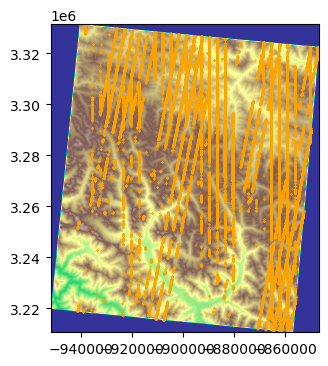

In [13]:
## check isat2 data and srtm
plt.figure(figsize=(4,4))
plt.subplot(1,1,1)
plt.imshow(srtm, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.scatter(x=isat2['x_albers'], y=isat2['y_albers'], marker='.',c='orange', s=0.2, zorder=0)


### Assign footprint type: stable (0), water (1), forest(2), glacier (3). 


In [14]:
isat2['type_fp'] = np.zeros_like(isat2['x_albers'])  ## stable type: 0
### water type determination, index number: 1
row_isat2_wat, col_isat2_wat = geo2imagexy(x=isat2['x_albers'], y=isat2['y_albers'], gdal_trans=srtm_info['geotrans'], integer=True)
ids_wat = np.where(mask_wat[row_isat2_wat, col_isat2_wat]==1)[0]
isat2['type_fp'][ids_wat]=1
### forest type determination, index number: 2
row_isat2_srtm, col_isat2_srtm = geo2imagexy(x=isat2['x_albers'], y=isat2['y_albers'], gdal_trans=srtm_info['geotrans'], integer=True)
ids_forest = np.where(mask_forest[row_isat2_srtm, col_isat2_srtm]==1)[0]
isat2['type_fp'][ids_forest]=2
### glacier type determination, index number: 3
row_isat2_srtm, col_isat2_srtm = geo2imagexy(x=isat2['x_albers'], y=isat2['y_albers'], gdal_trans=srtm_info['geotrans'], integer=True)
ids_glacier = np.where(mask_glacier[row_isat2_srtm, col_isat2_srtm]==1)[0]
isat2['type_fp'][ids_glacier]=3


Text(0.5, 1.0, 'gl30_forest')

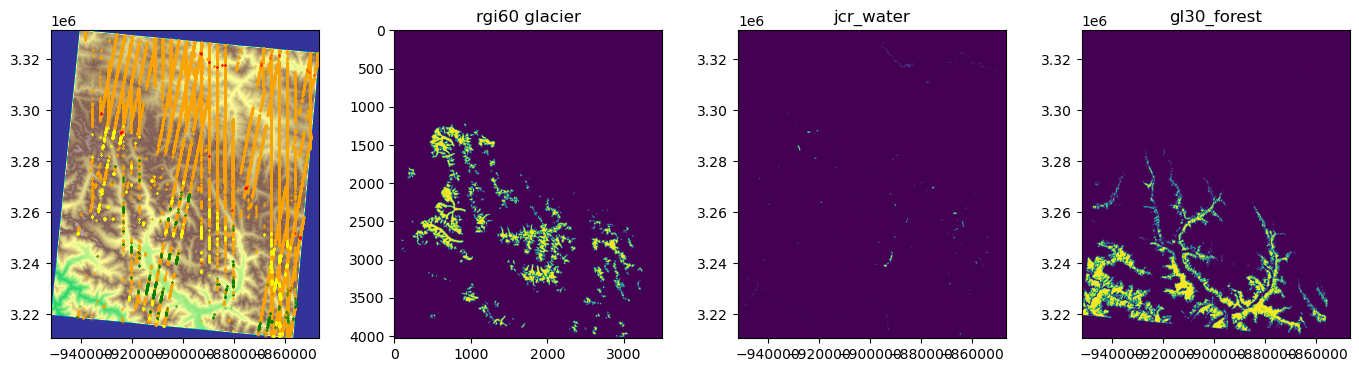

In [15]:
### Check the icesat2 data of different land cover types.
ids_stable = np.where(isat2['type_fp']==0)[0] 
ids_wat = np.where(isat2['type_fp']==1)[0] 
ids_forest = np.where(isat2['type_fp']==2)[0] 
ids_glacier = np.where(isat2['type_fp']==3)[0] 
plt.figure(figsize=(17,4))
plt.subplot(1,4,1)
plt.imshow(srtm, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.scatter(x=isat2['x_albers'][ids_stable], y=isat2['y_albers'][ids_stable], marker='.', c='orange', s=0.2, zorder=0)
plt.scatter(x=isat2['x_albers'][ids_wat], y=isat2['y_albers'][ids_wat], marker='.',c='red', s=0.2, zorder=0)
plt.scatter(x=isat2['x_albers'][ids_forest], y=isat2['y_albers'][ids_forest], marker='.', c='green', s=0.2, zorder=0)
plt.scatter(x=isat2['x_albers'][ids_glacier], y=isat2['y_albers'][ids_glacier], marker='.', c='yellow', s=0.2, zorder=0)
plt.subplot(1,4,2)
plt.imshow(mask_glacier)
plt.title('rgi60 glacier')
plt.subplot(1,4,3)
plt.imshow(mask_wat, extent=srtm_info['geoextent'])
plt.title('jcr_water')
plt.subplot(1,4,4)
plt.imshow(mask_forest, extent=srtm_info['geoextent'])
plt.title('gl30_forest')



### 1. Elevation difference on the glacier area.

In [16]:
## Select the icesat2 data which on the glacier area.
isat2_glacier = {}
for key in isat2:
  isat2_glacier[key] = isat2[key][isat2['type_fp']==3]
h_glacier_isat2 = isat2_glacier['h']


In [17]:
row_isat2_gla_srtm, col_isat2_gla_srtm = geo2imagexy(x=isat2_glacier['x_albers'], y=isat2_glacier['y_albers'], gdal_trans=srtm_info['geotrans'], integer=True)
h_glacier_srtm = srtm[row_isat2_gla_srtm, col_isat2_gla_srtm]
h_glacier_srtm.shape



(7224,)

In [18]:
h_glacier_dif_bins = {}
h_glacier_dif = h_glacier_isat2 - h_glacier_srtm 
h_glacier_dif[np.abs(h_glacier_dif)>150]=np.nan  ## filter the difference lager than 150 m.
bin_start, bin_end = np.floor(np.min(h_glacier_srtm)/100)*100, np.ceil(np.max(h_glacier_srtm)/100)*100
num_bin = ((bin_end - bin_start)/100).astype(int)
for i in range(num_bin):
  start, end = bin_start + i*100,  bin_start + i*100 + 100
  ids_bin = np.where((h_glacier_srtm < end) & (h_glacier_srtm > start))[0]
  h_glacier_dif_bins[str(start.astype(int))+'-'+str(end.astype(int))] = h_glacier_dif[ids_bin]
print(h_glacier_dif_bins.keys())


dict_keys(['3800-3900', '3900-4000', '4000-4100', '4100-4200', '4200-4300', '4300-4400', '4400-4500', '4500-4600', '4600-4700', '4700-4800', '4800-4900', '4900-5000', '5000-5100', '5100-5200', '5200-5300', '5300-5400', '5400-5500', '5500-5600', '5600-5700', '5700-5800', '5800-5900', '5900-6000'])


### Height difference values filter by using 2*sigma threshold

In [19]:
### remove the outlier values
h_glacier_dif_mean = np.nanmean(h_glacier_dif)
h_glacier_dif_sigma = np.nanstd(h_glacier_dif)
h_glacier_dif_filter = h_glacier_dif
h_glacier_dif_filter[np.abs(h_glacier_dif - h_glacier_dif_mean) > 3*h_glacier_dif_sigma]=np.nan
print('mean:', h_glacier_dif_mean)
print('standard deviation:', h_glacier_dif_sigma)


mean: -17.06623354536835
standard deviation: 15.943021209242422


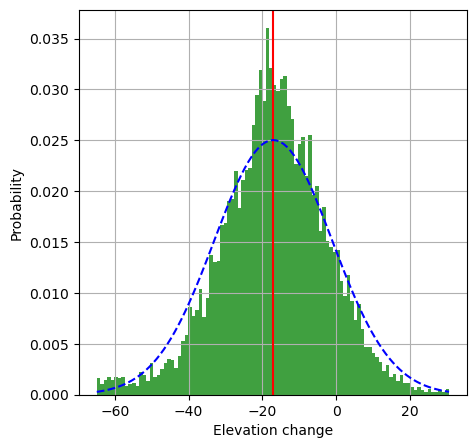

In [20]:
## The histogram of the data
plt.figure(figsize=(5,5))
n, bins, patches = plt.hist(h_glacier_dif_filter, bins=100, density=True, facecolor='g', alpha=0.75)
# n, bins, patches = plt.hist(h_glacier_dif, bins=100, range=(-80,40) ,density=True, facecolor='g', alpha=0.75)
plt.axvline(x=h_glacier_dif_mean, color='r')
y = ((1 / (np.sqrt(2 * np.pi) * h_glacier_dif_sigma)) *
     np.exp(-0.5 * (1 / h_glacier_dif_sigma * (bins - h_glacier_dif_mean))**2))
plt.plot(bins, y, 'b--')
plt.xlabel('Elevation change')
plt.ylabel('Probability')
plt.grid(True)


### 2. Elevation difference on the non-glacier stable area (exclude water, forest, and shrub coverage).

In [21]:
## Extract the icesat2 data which on the stale area.
isat2_stable = {}
for key in isat2:
  isat2_stable[key] = isat2[key][isat2['type_fp']==0]
h_stable_isat2 = isat2_stable['h']
h_stable_isat2.shape

(171953,)

In [22]:
## Extract the srtm data which on the stable area
row_isat2_stable_srtm, col_isat2_stable_srtm = geo2imagexy(x=isat2_stable['x_albers'], y=isat2_stable['y_albers'], gdal_trans=srtm_info['geotrans'], integer=True)
h_stable_srtm = srtm[row_isat2_stable_srtm, col_isat2_stable_srtm]
h_stable_srtm.shape


(171953,)

In [23]:
### elevation difference calculation
h_stable_dif_bins = {}
h_stable_dif = h_stable_isat2 - h_stable_srtm 
h_stable_dif[np.abs(h_stable_dif)>50]=np.nan  ## filter the difference lager than 150 m.


In [24]:
### remove the outlier values
h_stable_dif_mean = np.nanmean(h_stable_dif)
h_stable_dif_sigma = np.nanstd(h_stable_dif)
h_stable_dif_filter = h_stable_dif
h_stable_dif_filter[np.abs(h_stable_dif - h_stable_dif_mean) > 3*h_stable_dif_sigma]=np.nan
print('mean:', h_stable_dif_mean)
print('standard deviation:', h_stable_dif_sigma)


mean: -2.473665889258004
standard deviation: 8.394667732006253


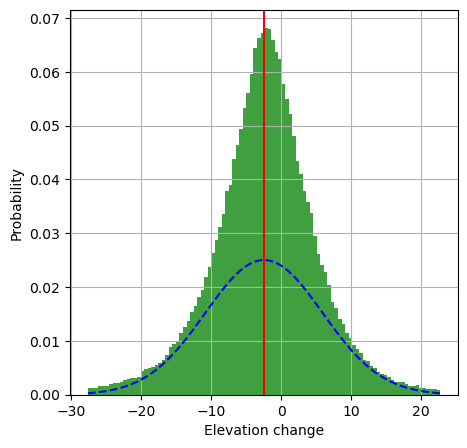

In [25]:
## The histogram of the data
plt.figure(figsize=(5,5))
n, bins, patches = plt.hist(h_stable_dif_filter, bins=100, density=True, facecolor='g', alpha=0.75)
# n, bins, patches = plt.hist(h_glacier_dif, bins=100, range=(-80,40) ,density=True, facecolor='g', alpha=0.75)
plt.axvline(x=h_stable_dif_mean, color='r')
y = ((1 / (np.sqrt(2 * np.pi) * h_glacier_dif_sigma)) *
     np.exp(-0.5 * (1 / h_stable_dif_sigma * (bins - h_stable_dif_mean))**2))
plt.plot(bins, y, 'b--')
plt.xlabel('Elevation change')
plt.ylabel('Probability')
plt.grid(True)
